In [1]:
import pickle
import torch
import sklearn
from tqdm import tqdm
import numpy as np
from asif import ASIF, extract_candidate_sets_from_clusters, compute_embedding
from transformers import AutoTokenizer, AutoModel
from matplotlib import pyplot as plt
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader

/home/luigi/anaconda3/envs/chocolm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def elbow(X, cluster_sizes, label = "Elbow curve"):
    distorsions = []
    result = []
    for k in tqdm(cluster_sizes):
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
        result.append(kmeans)
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cluster_sizes, distorsions)
    plt.xticks(cluster_sizes)
    plt.grid(True)
    plt.title(label)
    return result

In [ ]:
embedding_mode = "hs"

train_lyrics = pickle.load(open("experimental_data/train_lyrics.pkl", "rb"))
train_chords = pickle.load(open("experimental_data/train_chords.pkl", "rb"))

test_lyrics = pickle.load(open("experimental_data/test_lyrics.pkl", "rb"))
test_chords = pickle.load(open("experimental_data/test_chords.pkl", "rb"))

train_lyrics_embeddings = pickle.load(open(f"experimental_data/train_lyrics_embeddings_{embedding_mode}.pkl", "rb"))
train_chords_embeddings = pickle.load(open(f"experimental_data/train_chords_embeddings_{embedding_mode}.pkl", "rb"))

test_lyrics_embeddings = pickle.load(open(f"experimental_data/test_lyrics_embeddings_{embedding_mode}.pkl", "rb"))
test_chords_embeddings = pickle.load(open(f"experimental_data/test_chords_embeddings_{embedding_mode}.pkl", "rb"))

In [47]:
len(set(train_chords) - set(test_chords))

163058

100%|██████████| 8/8 [00:31<00:00,  3.94s/it]


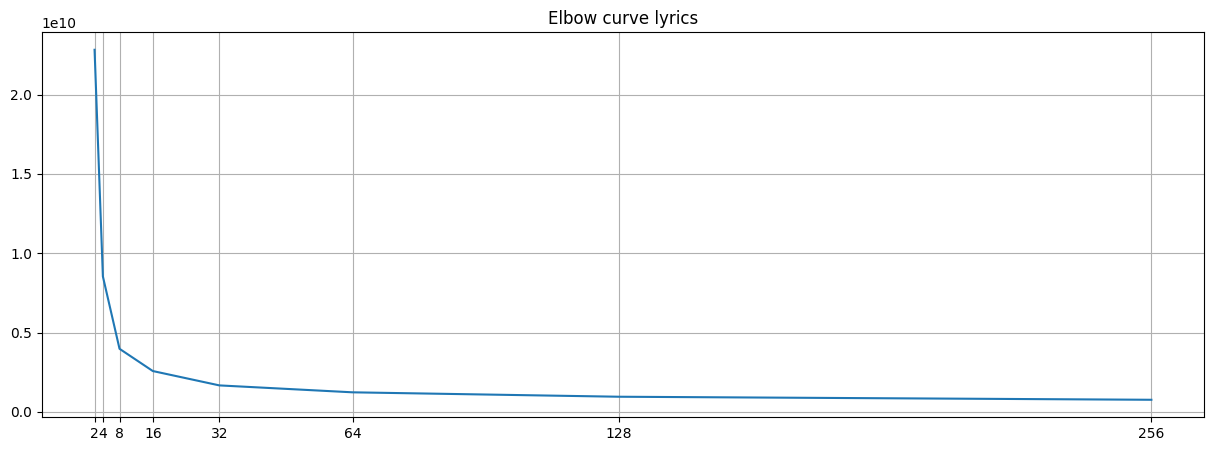

In [14]:
cluster_sizes = [2**p for p in range(1, 9)]
kmeans_runs_lyrics = elbow(train_lyrics_embeddings.numpy(), cluster_sizes, "Elbow curve lyrics")

100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


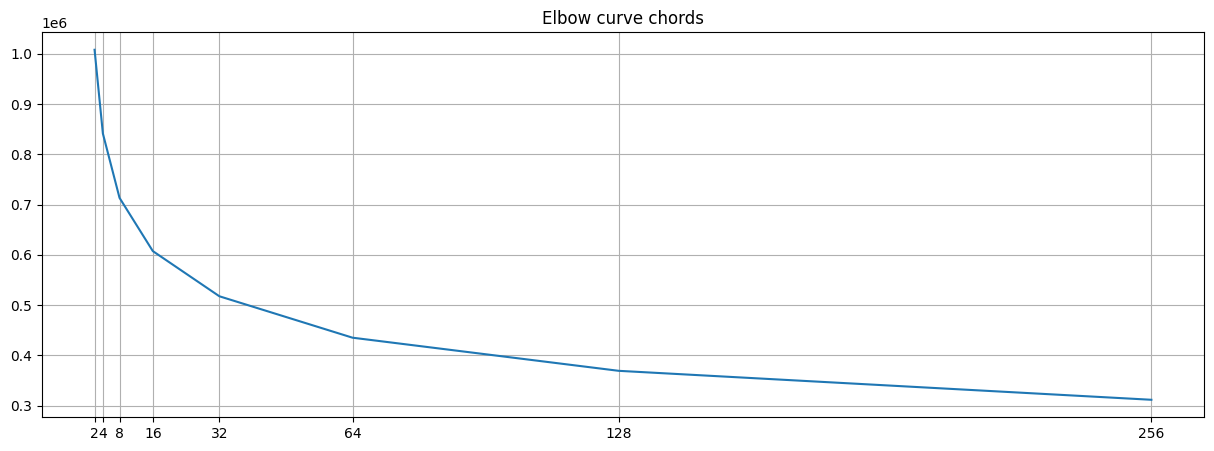

In [15]:
cluster_sizes = [2**p for p in range(1, 9)]
kmeans_runs_chords = elbow(train_chords_embeddings.numpy(), cluster_sizes, "Elbow curve chords")

In [18]:
# choose k = 8 for lyrics
kmeans_lyrics = kmeans_runs_lyrics[2]
# choose k = 16 for chords
kmeans_chords = kmeans_runs_chords[3]

In [19]:
lyrics_candidates = extract_candidate_sets_from_clusters(kmeans_lyrics, train_lyrics)
chords_candidates = extract_candidate_sets_from_clusters(kmeans_chords, train_chords)

In [20]:
asif = ASIF(
    lyrics_candidates,
    chords_candidates,
    torch.from_numpy(kmeans_lyrics.cluster_centers_),
    torch.from_numpy(kmeans_chords.cluster_centers_),
    train_lyrics_embeddings,
    train_chords_embeddings
)

In [24]:
test_lyrics_embeddings.size()

torch.Size([704304, 768])

In [28]:
test_relative_coordinates_lyrics = asif.compute_relative_coordinates_vs_space1(test_lyrics_embeddings[:1000])

In [30]:
sim = (1 / (1 + torch.cdist(test_relative_coordinates_lyrics, asif.candidate_embeddings2_rc)))

In [35]:
sim.argmax(dim=1)[0]

tensor(10)

In [36]:
test_chords[0]

'C:maj A:min7'

In [41]:
asif.candidates2[10].index(test_chords[0])

9471